<div align="center">
  <h1 style="color: skyblue;">
    Quantum Tree Generator for Quantum Approximate Optimization Algorithm (QTG-QAOA) for the Quadratic Knapsack Problem (QKP)
  </h1>
</div>


## 📘 Introduction: Quantum Tree Generator and Constraint-Preserving QAOA for 0-1 QKP

<div style="border-left: 4px solid #4CAF50; padding-left: 1em;">
    <span style="color: #4CAF50; font-weight: bold;">This notebook provides a technical overview</span> of the implementation of the <span style="color: #2196F3; font-weight: bold;">Quantum Tree Generator (QTG)</span> adapted to QAOA to solve the quadratic knapsack problem; QTG originally introduced by Sören Wilkening et al. in <em>"A Quantum Algorithm for Solving 0–1 Knapsack Problems"</em>. The purpose of the QTG is to generate a feasible quantum state, i.e., a superposition of bitstrings that satisfy the capacity constraint of the 0–1 knapsack problem and then implement a quantum search based on quantum grover algorithm. This works is inspired by the work of Paul Christiansen et al. in <em>"Quantum tree generator improves QAOA state-of-the-art for the knapsack problem"</em>, which extends the QTG state preparation to integrate it with the Quantum Approximate Optimization Algorithm (QAOA).
</div>

### 🎯 Goal
To encode feasibility directly into the initial state of the quantum algorithm. This guarantees that any quantum evolution will remain within the feasible subspace — a key requirement when applying QAOA to combinatorial optimization problems with hard constraints.

### 🧩 Quantum Tree Generator (QTG)
The QTG is a quantum circuit that builds a superposition of feasible knapsack solutions using a recursive tree structure, where amplitude is assigned only to those branches (bitstrings) that respect the weight constraint. This method scales efficiently for problems of moderate size and eliminates the need for costly penalty terms in the Hamiltonian.

### 🔧 Mixer Construction
We use the approach proposed by Paul Christiansen et al. in <em>"Quantum tree generator improves QAOA state-of-the-art for the knapsack problem"</em>, wich constructs a mixer in based to the QTG structure. The mixer is designed to preserve the feasibility of the solutions throughout the quantum evolution, ensuring that the QAOA algorithm explores only valid solutions.

### 📌 Context
This setup is applied to the <span style="color:#E91E63; font-weight:bold;">Quadratic Knapsack Problem (QKP)</span>, a generalization of the classical 0–1 Knapsack Problem where the profit function includes quadratic terms. The QAOA framework allows for encoding such problems via a cost Hamiltonian (derived from profit interactions) and a constraint-aware mixer (as above), enabling near-term quantum devices to approximate solutions.

---

### 📌 Requirements
To run this notebook, you need to have the Qiskit library installed. You can install it using pip:

```bash
    pip install qiskit
```


---
<div align="center">
  <h1 style="color: white;">
    START OF THE NOTEBOOK
  </h1>
</div>

## 📂 Instances

Ussually, the QKP instances are generated using the functions from the `QKP.instances_generator` module. This function creates a random instance of the QKP with specified parameters such as the number of items, capacity, and percentage of non-zero profit entries. But for this notebook, we will use the following instance as an example:

In [1]:
import numpy as np

n_items = 4
weights = [1, 1, 1, 1] 
profits = np.array([[7, 1, 3, 0],
                    [1, 1, 5, 1],
                    [3, 5, 7, 4],
                    [0, 1, 4, 1]]
                    )
capacity = 2

## 🌳 Quantum Tree Generator (QTG) 
The QTG is implemented in the `QKP.qtg_builder` module, which contains the `QTG` class. This class is responsible for generating a quantum circuit that encodes the feasible solutions of the QKP instance. Note that QTG circuit contains more qubits than the number of items in the QKP instance, as it uses additional qubits to encode the feasibility constraints (ancilla qubits). Unlike the original proposal of the QTG, which use the register for carry the profit, in this case, we will use just the register to carry the weight of the knapsack like Paul Christiansen et al. in <em>"Quantum tree generator improves QAOA state-of-the-art for the knapsack problem"</em>.

---
As is proposed by Sören Wilkening et al. is useful implement an intermedate solution for to bias the QTG circuit towards optimal solutions. The biased factor is choosen as $n/4$. 

## Here we implement a greedy algorithm to generate a intermediate solution.

In [2]:
from QKP.classical_solution import greedy_deletion_solution

greedy_ansatz = greedy_deletion_solution(n_items, weights, profits, capacity)
biased = n_items/2 

print("Greedy Ansatz:", greedy_ansatz)

Greedy Ansatz: [1, 0, 1, 0]


## Creation and measure for QTG circuit.

We will implement the QTG-QAOA scheme with and without biased hadamard gates to show the difference between both approaches. We will use the same initial parameters for both cases, set to $\gamma = \pi$ and $\beta = \pi/2$, which are common choices for the QAOA algorithm.

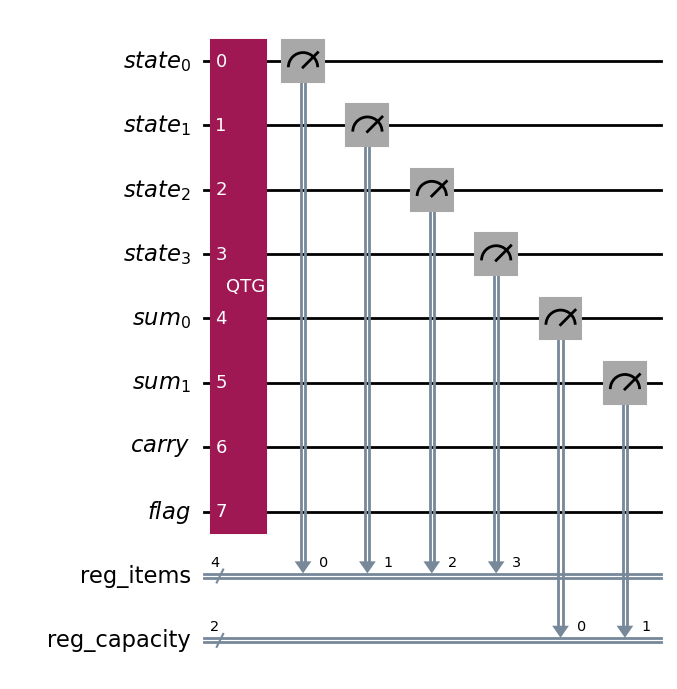

In [3]:
from qiskit import QuantumCircuit, transpile
from QTG.qtg_builder import QTG
from qiskit_aer import Aer
from qiskit.circuit import ClassicalRegister

qc_QTG = QuantumCircuit(n_items)         #Without biased hadamard gates
qc_QTG_biased = QuantumCircuit(n_items)  #With biased hadamard gates

qc_QTG = QTG(
        num_state_qubits=n_items,  
        weights=weights,  
        capacity=capacity)

qc_QTG_biased = QTG(
        num_state_qubits=n_items,    
        weights=weights,
        capacity=capacity,
        y_ansatz=greedy_ansatz, # Use the greedy ansatz to bias the hadamard gates
        biased=biased) 
                


reg_items = ClassicalRegister(n_items, 'reg_items')                       # Create a classical register to store the measurement results for the items 
reg_capacity = ClassicalRegister(capacity.bit_length(), 'reg_capacity')   # and capacity

qc_QTG.add_register(reg_items, reg_capacity) 
qc_QTG.measure(qc_QTG.qubits[0:n_items], reg_items)
qc_QTG.measure(qc_QTG.qubits[n_items:n_items+capacity.bit_length()], reg_capacity) 

qc_QTG_biased.add_register(reg_items, reg_capacity) 
qc_QTG_biased.measure(qc_QTG_biased.qubits[0:n_items], reg_items)
qc_QTG_biased.measure(qc_QTG_biased.qubits[n_items:n_items+capacity.bit_length()], reg_capacity) 


qc_QTG.draw('mpl')

## Transpilation and execution of the QTG circuit.

Is done using the Qiskit Aer simulator

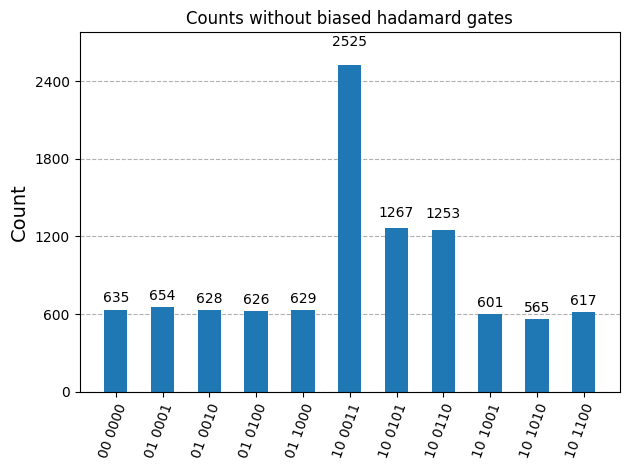

In [4]:
from qiskit.visualization import plot_histogram

# Execute the circuit without biased gates
simulator = Aer.get_backend('aer_simulator') # We use the Aer simulator backend for running the circuit
transpiled_circuit = transpile(qc_QTG, simulator)

shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()
counts = result.get_counts()

plot_histogram(counts, title="Counts without biased hadamard gates")

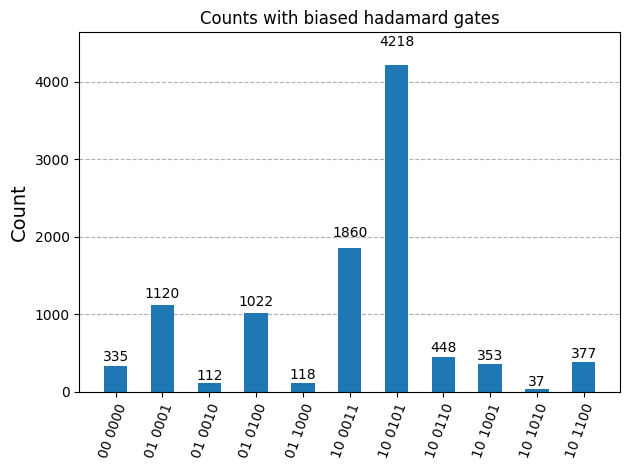

In [5]:
# Execute the circuit with biased gates
transpiled_circuit_biased = transpile(qc_QTG_biased, simulator)

shots = 10_000
job = simulator.run(transpiled_circuit_biased, backend=simulator, shots=shots)
result = job.result()
counts = result.get_counts()

plot_histogram(counts, title="Counts with biased hadamard gates")

Note that the capacity is never exceeded (3 correspond 11 in binary). Basically the items selection in the example is all the possible ways to choose 2 items out of a total of 4, since each one weighs 1. And also note that the probability of the biased state given by the greedy solution (reading string bits in qiskit is done from right to left) has increased to a greater extent in the second circuit.

## Construction of constraint-preserving mixer for QAOA

The `build_qtg_mixer` function constructs a mixer operator that preserves the feasible subspace of QKP as is proposed by Paul Christiansen et al. in <em>"Quantum tree generator improves QAOA state-of-the-art for the knapsack problem"</em>. This mixer is designed to work with the QTG circuit and ensures that the quantum evolution remains within the feasible solutions of the QKP.


In [6]:
from QAOA.qtg_mixer import build_qtg_mixer

qc_QTG.remove_final_measurements()  # Remove final measurements
qc_QTG_biased.remove_final_measurements()  

qtg_mixer = build_qtg_mixer(qc_QTG)
qtg_mixer_biased = build_qtg_mixer(qc_QTG_biased)

---
Up to this point we haven't used the profits matrix $Q^{n \times n}$ (except the greedy solution but this is not strictly necessary), since the preparation of the initial state and the constraint mixer only depend on the problem restriction, that is, the capacity and the weights, therefore this procedure would be unique for the same instance independent of the utility matrix $Q$. That means, this **state and mixer is recyclable** for an similar instance with a different Q.

## 📈 QAOA Implementation

Here we will build the hamiltonian to otpimize in based of the profits matrix $x^T Q x$ using the `QAOA.qaoa.build_qkp_cost_hamiltonian` function, note that is neccesary to extend with identity the hamiltonian to match the number of qubits ($n + ancilla$) in the QTG circuit using the `QAOA.qaoa.operator_extend` function. After that, we will prepare the QAOA circuit using the QTG circuit as the initial circuit and the QTG-mixer as mixer operator. Note that the hamiltonian is unconstrained like QUBO problems.

---
Unlike the approach by Paul Christiansen et al., which addresses the linear knapsack problem, we implement a phase separator derived from the quadratic profit matrix $Q^{n \times n}$ of the QKP instance. Furthermore, our method requires neither prior computations nor storage of classical information.


In [7]:
from QAOA.cost_operator import build_qkp_cost_hamiltonian, operator_extend

cost_hamiltonian = build_qkp_cost_hamiltonian(n_items, profits)
cost_hamiltonian = operator_extend(cost_hamiltonian, qc_QTG.num_qubits)

print("Cost Hamiltonian: ", cost_hamiltonian)

Cost Hamiltonian:  SparsePauliOp(['IIIIIIIZ', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIIIZI', 'IIIIIZZI', 'IIIIZIZI', 'IIIIIZII', 'IIIIZZII', 'IIIIZIII'],
              coeffs=[ 3.75+0.j, -0.5 +0.j, -1.5 +0.j,  3.75+0.j, -2.5 +0.j, -0.5 +0.j,
  7.75+0.j, -2.  +0.j,  2.75+0.j])


Now all that remains is to use Qiskit's QAOAAnsatz function to solve the problem. The optimization is performed only in the feasible space, so the solution must satisfy the constraint.

In [8]:
from qiskit.circuit.library import QAOAAnsatz

reps1 = 10
reps2 = 3

qaoa= QAOAAnsatz(
    cost_operator=cost_hamiltonian,
    mixer_operator=qtg_mixer.decompose().decompose(),
    initial_state=qc_QTG,
    reps=reps1,
    name="QAOA_QKP" 
)

qaoa_biased= QAOAAnsatz(
    cost_operator=cost_hamiltonian,
    mixer_operator=qtg_mixer_biased.decompose().decompose(),
    initial_state=qc_QTG_biased,
    reps=reps2,
    name="QAOA_QKP_biased" 
)


The fllowing is parameter optimization for QAOA using the `minimize` function from `scipy.optimize`. The optimization is performed using the COBYLA method, which is a derivative-free optimization algorithm. The objective function is the expectation value of the cost Hamiltonian with respect to the QAOA circuit.


In [9]:
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

init_params1 = [initial_gamma, initial_beta] * reps1
init_params2 = [initial_gamma, initial_beta] * reps2

estimator = AerEstimator()
estimator.set_options(shots=10_000)

def cost_func_estimator(params, ansatz, hamiltonian, estimator, objective_func_vals):
    circuit_bound = ansatz.decompose().decompose().assign_parameters(params, inplace=False)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

## Optimization of the QAOA parameters for the QTG without biased gates

In [10]:
objective_func_vals = []
result = minimize(
    cost_func_estimator,
    init_params1,
    args=(qaoa, cost_hamiltonian, estimator, objective_func_vals),
    method="COBYLA", 
    tol=1e-5,
    options={'maxiter': 5000}
)

print("Optimization Result:\n", result)

Optimization Result:
  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.5426500000000001
       x: [ 4.222e+00  1.487e+00 ...  3.113e+00  1.521e+00]
    nfev: 246
   maxcv: 0.0


## Optimization of the QAOA parameters for the QTG with biased gates

In [11]:
objective_func_vals_biased = []

result_biased = minimize(
    cost_func_estimator,
    init_params2,
    args=(qaoa_biased, cost_hamiltonian, estimator, objective_func_vals_biased),
    method="COBYLA", 
    tol=1e-5,
    options={'maxiter': 5000}
)

print("Optimization Result with biased gates:\n", result_biased)

Optimization Result with biased gates:
  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.9995
       x: [ 4.132e+00  1.714e+00  4.120e+00  2.499e+00  3.174e+00
            1.551e+00]
    nfev: 75
   maxcv: 0.0


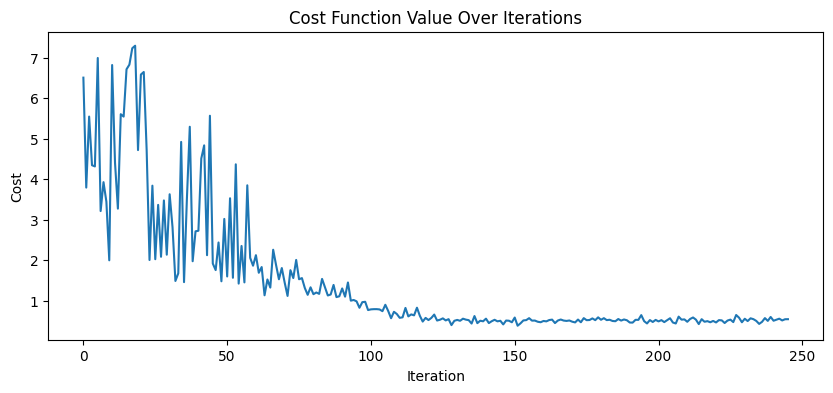

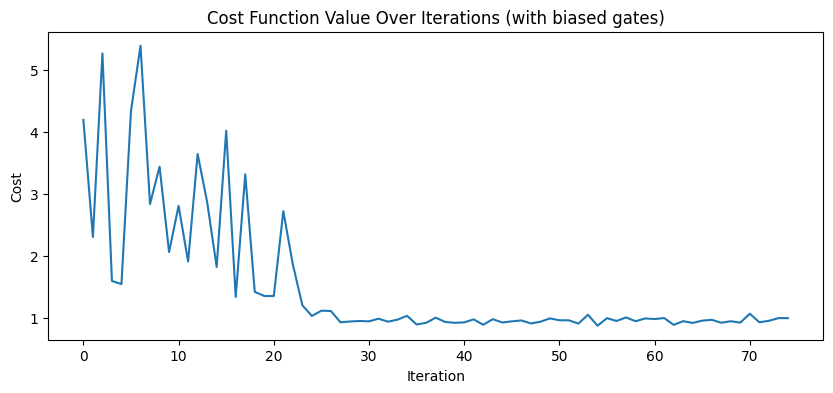

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function Value Over Iterations")
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(objective_func_vals_biased)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function Value Over Iterations (with biased gates)")
plt.show()

## Assignment of the optimized parameters to the QAOA circuit and measurement of the qubits

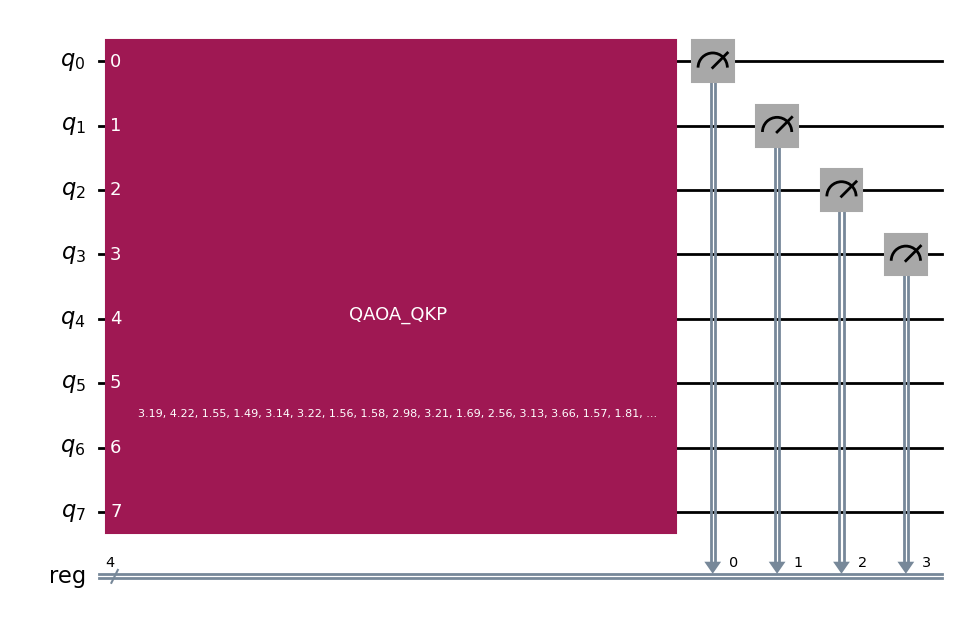

In [13]:
reg = ClassicalRegister(n_items, 'reg')

optimized_circuit = qaoa.assign_parameters(result.x)   # Assign the optimized parameters to the QAOA circuit and measure the qubits
optimized_circuit.add_register(reg)
optimized_circuit.measure(qaoa.qubits[0:n_items], reg)
optimized_circuit.draw('mpl')

In [14]:
optimized_circuit_biased = qaoa_biased.assign_parameters(result_biased.x)   # Assign the optimized parameters to the QAOA circuit and measure the qubits
optimized_circuit_biased.add_register(reg)
optimized_circuit_biased.measure(qaoa_biased.qubits[0:n_items], reg)

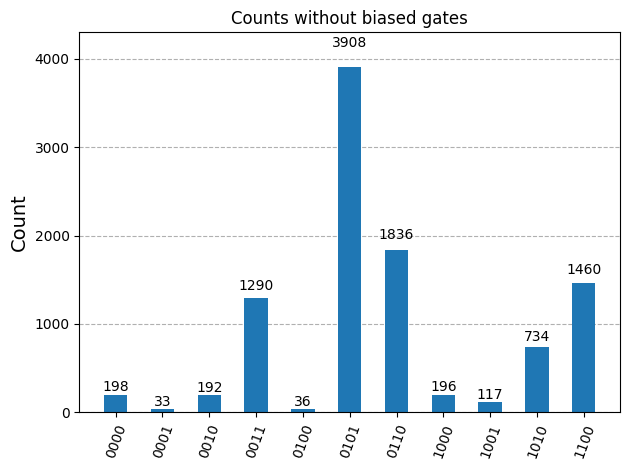

In [15]:
# Execute the optimized circuit without biased gates

transpiled_circuit = transpile(optimized_circuit.decompose().decompose(), simulator)
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

counts = result.get_counts()
plot_histogram(counts, title="Counts without biased gates")

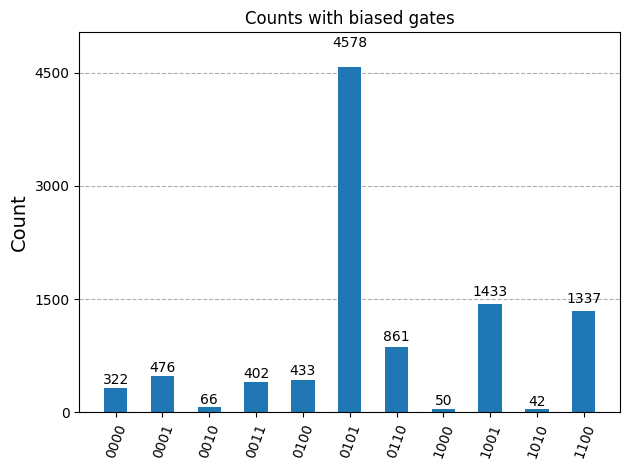

In [16]:
# Execute the optimized circuit with biased gates

transpiled_circuit = transpile(optimized_circuit_biased.decompose().decompose(), simulator)
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

counts_biased = result.get_counts()
plot_histogram(counts_biased, title="Counts with biased gates")

## Comparison of the results

Is clear that the biased gates approach leads to a more probable solution, which is expected since the biased gates are designed to favor the optimal solution. And also the parameters optimization is achvied in less iterations in the biased case. Withot biased gates we need more layers to achieve a similar result.

In [17]:
from QKP.classical_solution import solve_qkp_cplex

most_probable_solution, probability = max(counts.items(), key=lambda kv: kv[1])
most_probable_solution_biased, probability_biased = max(counts_biased.items(), key=lambda kv: kv[1])

probability /= shots
probability_biased /= shots

most_probable_solution = most_probable_solution[::-1]
most_probable_solution_biased = most_probable_solution_biased[::-1] # Reverse the string to match the original order

real_solution = solve_qkp_cplex("QKP\Instances\example_summary.txt")

print("Most probable solution without biased gates:", most_probable_solution, "with probability:", probability)
print("Most probable solution with biased gates   :", most_probable_solution_biased, "with probability:", probability_biased)   
print("Real solution:", int(real_solution[1]))
    

Most probable solution without biased gates: 1010 with probability: 0.3908
Most probable solution with biased gates   : 1010 with probability: 0.4578
Real solution: 1010


<div align="center">
  <h1 style="color: skyblue;">
    QTG-QAOA Implementation for the Densest Subgraph Problem (Uniform Quadratic Knapsack)
  </h1>
</div>

In this section, we implement the QTG-QAOA algorithm for the *Densest Subgraph Problem*, which can be interpreted as a special case of the Quadratic Knapsack Problem (QKP) where all items have **unit weight**.

This variation simplifies the capacity constraint: instead of checking the total weight of selected items, the problem reduces to selecting **exactly $k$ items**, where $k$ is determined by the capacity value. Formally, the goal is to find a subset of $k$ vertices that maximizes the sum of edge weights among them, i.e., to find the densest $k$-subgraph.

Given this uniform-weight structure, we benefit from a much more efficient **mixer Hamiltonian**, tailored to preserve Hamming weight.

#### <span style="color:#E91E63; font-weight:bold;">Hamming Weight Mixer</span>

Unlike the general QKP case where the mixer must be constructed with the aid of the **Quantum Tree Generator (QTG)**, in this uniform setting we can exploit a simpler and more efficient mixer: the **Hamming Weight Mixer**, which preserves the number of qubits in state $|1\rangle$ throughout the evolution.

This is crucial because the feasible subspace of the problem consists of all bitstrings with Hamming weight $k$, i.e., all states with exactly $k$ ones.

The Hamming Weight Mixer is given by the Hamiltonian:

$$
H_M = \sum_{i < j} \left( X_i X_j + Y_i Y_j \right)
$$

This operator generates transitions between states of equal Hamming weight by swapping $|10\rangle \leftrightarrow |01\rangle$, which ensures that the number of selected items remains constant during the QAOA evolution.

Since we already prepare the initial state using the **Quantum Tree Generator (QTG)** in a superposition of feasible states (all of Hamming weight $k$ or less), evolving under this mixer will restrict the search strictly to the feasible subspace, making the algorithm both **more efficient and more physically realistic to implement**, as fewer gates are required compared to more general constructions.

> ⚠️ Note: This formulation avoids the need for costly ancilla-based constructions or tree-structured mixers. It uses only native 2-qubit gates and leverages the combinatorial structure of the solution space.


---
## 📂 Instances

The insances generated for this section are based on the same principles as the previous QKP instances, but with a focus on the uniform weight case. The `densest_instance` function from the `QKP.instances_generator` module can be used to create these instances.

In [18]:
from QKP.instances_generator import instance_generator
from QKP.Instances.read_instances import read_instance

test = 1
instance_generator(n=5, pct=60, instance_type="densest", test_id=1)

n_items, profits, weights, capacity = read_instance(f"QKP\Instances\densest\instance_densest_{test}.txt")

print("Profits:\n", profits)
print("\nWeights:", weights)  
print("\nCapacity:", capacity)

Profits:
 [[0 1 1 1 1]
 [1 0 1 0 1]
 [1 1 0 0 0]
 [1 0 0 0 1]
 [1 1 0 1 0]]

Weights: [1, 1, 1, 1, 1]

Capacity: 3


## 🌳 Quantum Tree Generator (QTG) 

In [19]:
from qiskit import QuantumCircuit, transpile
from QTG.qtg_builder import QTG
from qiskit_aer import Aer
from qiskit.circuit import ClassicalRegister
from QKP.classical_solution import greedy_deletion_solution

greedy_ansatz = greedy_deletion_solution(n_items, weights, profits, capacity)
biased = n_items/2 

print("Greedy Ansatz:", greedy_ansatz)

qc_QTG = QuantumCircuit(n_items)        

qc_QTG = QTG(
        num_state_qubits=n_items,  
        weights=weights,  
        capacity=capacity,
        y_ansatz=greedy_ansatz,
        biased=biased,
        name="QTG_QKP_densest"
        )

Greedy Ansatz: [1, 0, 0, 1, 1]


## Construction of Hamming Weight Mixer for QAOA

In [20]:
from QAOA.hamming_weight_mixer import build_hamming_weight_mixer

hamming_mixer = build_hamming_weight_mixer(n_items, qc_QTG.num_qubits, capacity)

## QAOA Implementation

In [21]:
from QAOA.cost_operator import build_qkp_cost_hamiltonian, operator_extend

cost_hamiltonian = build_qkp_cost_hamiltonian(n_items, profits)
cost_hamiltonian = operator_extend(cost_hamiltonian, qc_QTG.num_qubits)

In [22]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize

reps = 5   # Number of layers in the QAOA circuit

qaoa= QAOAAnsatz(
    cost_operator=cost_hamiltonian,
    mixer_operator=hamming_mixer,
    initial_state=qc_QTG,
    reps=reps,
    name="QAOA_QKP" 
)

In [ ]:
import numpy as np

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps

estimator = AerEstimator()
estimator.set_options(shots=10_000)

def cost_func_estimator(params, ansatz, hamiltonian, estimator, objective_func_vals):
    circuit_bound = ansatz.decompose().decompose().assign_parameters(params, inplace=False)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

objective_func_vals = []

result = minimize(
    cost_func_estimator,
    init_params,
    args=(qaoa, cost_hamiltonian, estimator, objective_func_vals),
    method="COBYLA", 
    tol=1e-5,
    options={'maxiter': 5000}
)

print("Optimization Result:\n", result)

Optimization Result:
  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7415999999999998
       x: [ 3.200e+00  1.581e+00  3.078e+00  1.552e+00  3.192e+00
            1.550e+00  3.142e+00  2.541e+00  3.143e+00  1.573e+00]
    nfev: 210
   maxcv: 0.0


In this case take less time to optimize even with more qubits, since the the Hamming Weight Mixer is simpler and more efficient than the QTG-based mixer.

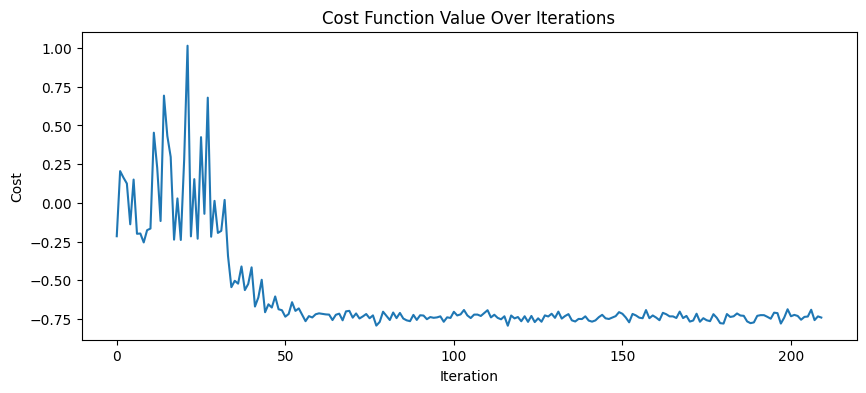

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function Value Over Iterations")
plt.show()

## Assignment of the optimized parameters to the QAOA circuit and measurement of the qubits

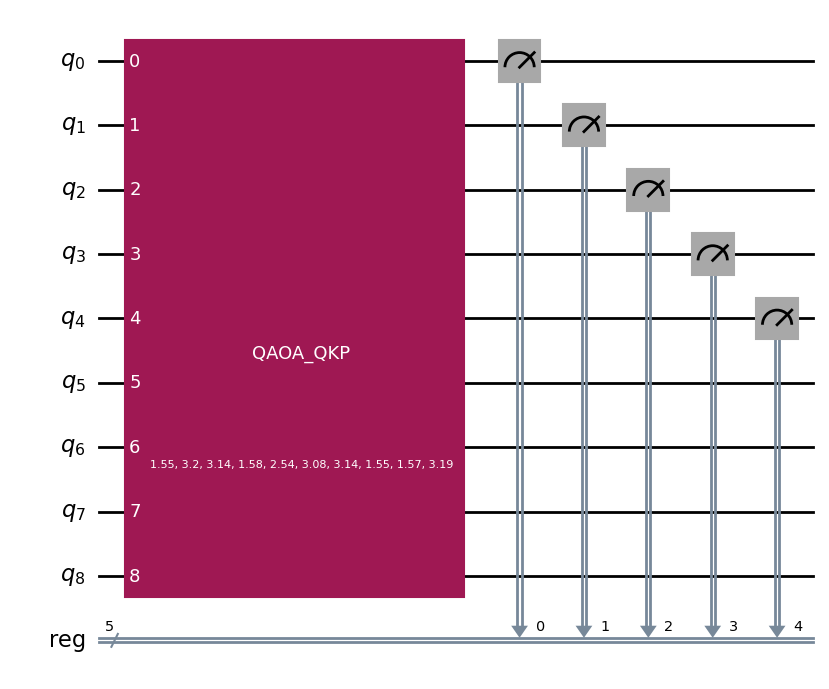

In [25]:
reg = ClassicalRegister(n_items, 'reg')

optimized_circuit = qaoa.assign_parameters(result.x)   # Assign the optimized parameters to the QAOA circuit and measure the qubits
optimized_circuit.add_register(reg)
optimized_circuit.measure(qaoa.qubits[0:n_items], reg)
optimized_circuit.draw('mpl')

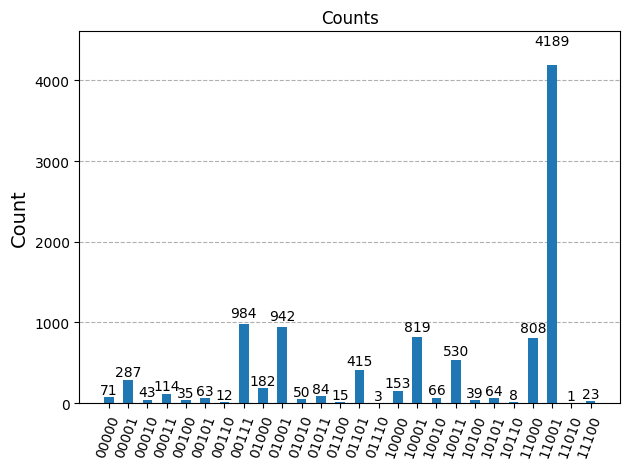

In [26]:
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit.decompose().decompose(), simulator)
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

counts = result.get_counts()
plot_histogram(counts, title="Counts")

In [27]:
def calculate_profit(solution, profits):
    profit = 0
    n = len(solution)
    for i in range(n):
        if solution[i] == '1':
            for j in range(n):
                if solution[j] == '1':
                    profit += profits[i, j]
    return profit

In [28]:
from QKP.classical_solution import solve_qkp_cplex

most_probable_solution, probability = max(counts.items(), key=lambda kv: kv[1])
probability /= shots

most_probable_solution = most_probable_solution[::-1] # Reverse the string to match the original order
value = calculate_profit(most_probable_solution, profits)

real_solution = solve_qkp_cplex(f"QKP\Instances\densest\instance_densest_{test}.txt")

print("Most probable solution:", value,",", most_probable_solution, "with probability:", probability)   
print("Real solution:", real_solution)
    

Most probable solution: 6 , 10011 with probability: 0.4189
Real solution: [6, '11001']


The results of the QAOA implementation for the Densest Subgraph Problem using the Hamming Weight Mixer are really good, and the probability of the most probable solution is higher in comparison with the other states.

<div align="center">
  <h1 style="color: skyblue;">
    QTG-QAOA Convergence Analysis
  </h1>
</div>

In the following section, we empirically analyze the convergence behavior of the QAOA algorithm initialized with a Quantum Tree Generator (QTG) state. Our aim is to determine how the rate and quality of convergence towards optimal or near-optimal solutions depend on two key factors: the number of QAOA parameters ($\vec{\gamma}, \vec{\beta}$) (denoted by $p$) that is the number of layers in QAOA, and the classical optimization parameters, particularly the tolerance level and the maximum number of iterations allowed in the classical optimizer.

The performance metric is the approximation ratio, defined as the expected value of the cost function with respect to the variational state over the optimal value, i.e.,
$$
\text{Approximation Ratio} = \frac{\langle \psi(\boldsymbol{\gamma}, \boldsymbol{\beta}) | H | \psi(\boldsymbol{\gamma}, \boldsymbol{\beta}) \rangle}{\max_{x \in \mathcal{F}} f(x)},
$$
where $H$ is the phase-separating Hamiltonian encoding the QKP objective function, and $|\psi(\boldsymbol{\gamma}, \boldsymbol{\beta})\rangle$ is the state produced after $p$ alternating applications of the cost and mixing unitaries starting from the QTG-initialized feasible state.

We evaluate this convergence under varying values of:

- **Layer depth $p$**: from shallow circuits (e.g., $p=1$) to moderate depths (e.g., $p=10$), subject to simulation constraints.
- **Classical optimization tolerance** $\varepsilon$: smaller values imply tighter convergence requirements.
- **Maximum number of classical iterations**: this acts as a hard cutoff in the variational loop.

We present both convergence curves and heatmaps of final approximation ratios as a function of $(p, \varepsilon)$ and $(p, \text{max\_iterations})$, enabling insight into the trade-offs between circuit depth and optimizer settings.

We now proceed to run and visualize these experiments.


We take the following instance with 5 items, and $pct = 50\%$ for our analysis.

In [29]:
from QKP.Instances.read_instances import read_instance
n, profits, weights, capacity = read_instance("QKP\Instances\example_compairson.txt")

print("Profits:\n", profits)
print("\nWeights:", weights)  
print("\nCapacity:", capacity)

Profits:
 [[23 34 48 22 30]
 [34 35 31 15 19]
 [48 31 18 28 48]
 [22 15 28 33 13]
 [30 19 48 13 48]]

Weights: [4, 17, 11, 13, 6]

Capacity: 49


# Layer depth ($p$)

In [ ]:
import time
from QKP. solve_QKP import solve_QKP
from QKP.classical_solution import solve_qkp_cplex

# Solve the QKP instance using CPLEX
classical_solution = solve_qkp_cplex("QKP\Instances\example_compairson.txt", save_solution=False)

# Solve the QKP instance using QTG-QAOA for different number of layers
layers =[1, 5, 10]  # Define the number of layers to test
times = []
quantum_solutions = []
objective_func_vals_layers = []
for layer in layers:
    start_time = time.time()
    quantum_solution, greedy_ansatz, objective_func_vals = solve_QKP("QKP\Instances\example_compairson.txt", instance_type="standard", 
                                                    reps=layer, shots=100, tol=1e-10, iterations=1000, biased=1/2, convergence = True, callback_bool=False, save=False)
    end_time = time.time()
    quantum_solutions.append(quantum_solution)
    times.append((end_time - start_time) / 60)
    objective_func_vals_layers.append(objective_func_vals)
    print("Finished run with", layer, "layers\n")
     
print(f"Value CPLEX: {classical_solution[0]}")
print(f"Greedy Value: {greedy_ansatz[0]}")

for i, layer in enumerate(layers):
    print(f"\nValue QTG-QAOA with {layer} layers: {quantum_solutions[i][0]}")
    print(f"Time QTG-QAOA with {layer} layers: {times[i]} minutes")

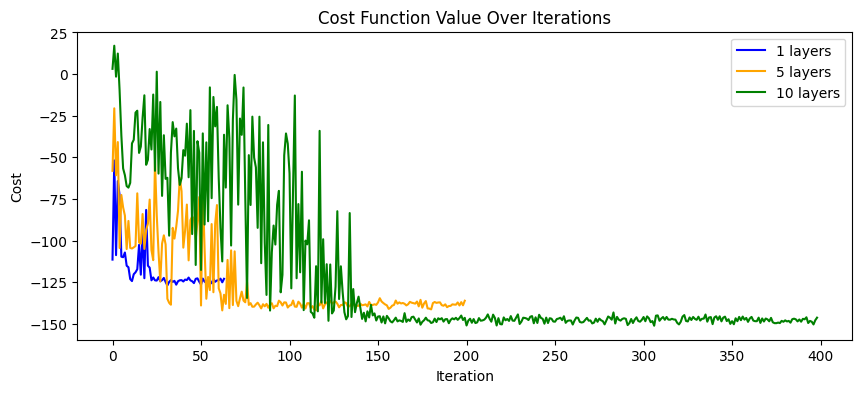

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(objective_func_vals_layers[0], label=f"{layers[0]} layers", color='blue')
plt.plot(objective_func_vals_layers[1], label=f"{layers[1]} layers", color='orange')
plt.plot(objective_func_vals_layers[2], label=f"{layers[2]} layers", color='green')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function Value Over Iterations")
plt.legend()
plt.show()

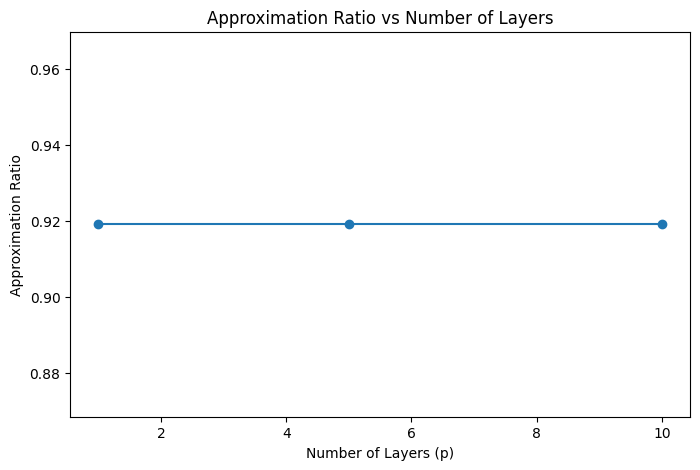

In [3]:
# Approximation ratios

approx_ratios = [quantum_solutions[i][0]/classical_solution[0] for i in range(len(layers))]
plt.figure(figsize=(8, 5))
plt.plot(layers, approx_ratios, marker='o')
plt.xlabel("Number of Layers (p)")
plt.ylabel("Approximation Ratio")
plt.title("Approximation Ratio vs Number of Layers")
plt.show()